In [1]:
from pathlib import Path

# Get the current working directory as a Path object
current_path = Path.cwd()
home_folder = 'evan_home'

# Traverse up the directory tree until you find the target folder
for parent in [current_path] + list(current_path.parents):
    if parent.name == home_folder:
        home_path = parent
        break
else:
    raise ValueError(f"Folder '{home_folder}' not found in the current working directory.")

print("Home Path:", home_path)
source_code_dir = home_path / 'Source_code'
dataset_dir = home_path / 'Dataset'


Home Path: c:\Users\evanlee\Documents\Bmi_NAS_evan\evan_home


In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import json
import os
import re
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

In [3]:
### Read representative cells
# types = ['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']
# adata = sc.read_h5ad('/home/jovyan/work/Research_datasets/PBMC_Hao/GSE164378_Hao/Harmony_noZ/Hao_L1_repcells_loginv_Harmony_noZ.h5ad')
# adata = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/PBMC_Hao/GSE164378_Hao/Harmony_noZ/Hao_L1_repcells_loginv_Harmony_noZ.h5ad')
adata = sc.read_h5ad(dataset_dir / 'PBMC_Hao/GSE164378_Hao/Harmony_noZ/Hao_L1_repcells_loginv_Harmony_noZ.h5ad')

print('Original adata:', adata.shape)
label = adata.obs['celltype.l1'].tolist()
types = np.unique(label).tolist()
print('all cell types:', types)

Original adata: (59897, 27504)
all cell types: ['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']


In [15]:
Hao_genes = adata.var_names.tolist()
len(Hao_genes)

27504

## Fisher exact test

In [14]:
import scipy.stats as stats

def perform_fisher_test(PreLect_genes, ACT_genes, Hao_genes):
    """
    Performs Fisher's exact test on the provided gene sets.

    Parameters:
    - PreLect_genes: Set of genes in PreLect_genes.
    - ACT_genes: Set of genes in ACT_genes.
    - Hao_genes: Set of all genes in Hao_genes (background population).

    Returns:
    - oddsratio: The odds ratio calculated from the contingency table.
    - p_value: The p-value from Fisher's exact test.
    """
    # Ensure the inputs are sets
    PreLect_genes = set(PreLect_genes)
    ACT_genes = set(ACT_genes)
    Hao_genes = set(Hao_genes)

    # Calculate the counts for the contingency table
    a = len(PreLect_genes & ACT_genes)                   # Genes in both PreLect_genes and ACT_genes
    b = len(PreLect_genes - ACT_genes)                   # Genes in PreLect_genes but not in ACT_genes
    c = len(ACT_genes - PreLect_genes)                   # Genes in ACT_genes but not in PreLect_genes
    d = len(Hao_genes - (PreLect_genes | ACT_genes))     # Genes in neither gene set

    # Construct the contingency table
    contingency_table = [[a, b],
                         [c, d]]

    # Perform Fisher's exact test
    oddsratio, p_value = stats.fisher_exact(contingency_table)

    # Output the results
    print("Contingency Table:")
    print(f"                   In ACT_genes    Not in ACT_genes")
    print(f"In PreLect_genes       {a}               {b}")
    print(f"Not in PreLect_genes   {c}            {d}")
    print(f"\nOdds Ratio: {oddsratio}")
    print(f"P-value: {p_value}")

    return oddsratio, p_value

# OR > 1: 
#   Indicates a positive association between being in PreLect_genes and being in ACT_genes
#   Genes in PreLect_genes are more likely to be in ACT_genes compared to genes not in PreLect_genes
#   The higher the OR, the stronger the positive association between PreLect_genes and ACT_genes


## Read ACT markers

In [4]:
# marker_df = pd.read_csv('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch_noZ/Level1/ACT_annotation/Human_blood_marker_processed.csv')
marker_df = pd.read_csv(source_code_dir / 'PBMC_Hao_batch_noZ/Level1/ACT_annotation/Human_blood_marker_processed.csv')
print(marker_df.shape)
marker_df.head()

(147, 6)


,Species,Tissue,super_type,CellType,Marker,Resource
0,Human,Blood,B,Activated B cell,"CD5, MIR155HG, TAGLN2","35025971, 28910360, 2474446"
1,Human,Blood,T_CD4,"Activated CD4-positive, alpha-beta T cell","CD4, CCR6, CD14, CD19, CD38, CD3D, CD3G, CD69,...","35381424, 32783921, 35831277, 34529726, 103413..."
2,Human,Blood,T_CD4,"Activated CD4-positive, CD25-positive, CCR4-po...","CD3D, CD3E, CD3G, CD4, FOXP3",30977974
3,Human,Blood,NaN,Adult endothelial progenitor cell,"KDR, PROM1, CD34, PTPRC, PECAM1, CD14","27561827, 29391882, 24641802, 29147957, 267700..."
4,Human,Blood,T,Alpha-beta T cell,"CD3D, CD3E, CD3G, IL7R","34284174, 28777444"


In [4]:
def get_celltype_marker(name, marker_df):
    string = marker_df[marker_df['CellType'] == name]['Marker'].tolist()[0]
    marker_set = set(string.split(', '))
    return marker_set

In [5]:
ACT_name = ['B cell', 'CD4-positive, alpha-beta T cell', 'CD8-positive, alpha-beta T cell', 'Dendritic cell', 'Monocyte', 'Natural killer cell']
cluster_2_ACT_name = dict(zip(types, ACT_name))
cluster_2_ACT_name

{'B': 'B cell',
 'CD4_T': 'CD4-positive, alpha-beta T cell',
 'CD8_T': 'CD8-positive, alpha-beta T cell',
 'DC': 'Dendritic cell',
 'Mono': 'Monocyte',
 'NK': 'Natural killer cell'}

## B: Read PreLect features at various lambdas

In [5]:
# os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch_noZ/Level1/large_lambda_various/at_various_number/features_at_various_no')
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level1/large_lambda_various/at_various_number/features_at_various_no')

celltype = 'B'
# Define the regular expression pattern using the celltype variable
pattern = re.compile(r'^{}_([0-9\.eE+-]+)_features\.txt$'.format(celltype))
# start with B_, followed by a number (which can include digits, decimal points, signs, and exponential notation), and end with _features.txt

# Get files with matching pattern
filenames = os.listdir()
matching_files = [filename for filename in filenames if pattern.match(filename)]
matching_files

['B_0.00031622776601683783_features.txt',
 'B_0.0006812920690579617_features.txt',
 'B_0.0014677992676220694_features.txt',
 'B_0.003162277660168382_features.txt',
 'B_0.006812920690579613_features.txt',
 'B_0.014677992676220709_features.txt',
 'B_0.0316227766016838_features.txt']

In [12]:
float(matching_files[0].split('_')[1])

0.003162277660168382

In [19]:
ACT_genes_celltype = get_celltype_marker(cluster_2_ACT_name[celltype], marker_df)
len(ACT_genes_celltype)
# ACT_genes: remove any that are not part of Hao_genes
ACT_genes_celltype = set(ACT_genes_celltype).intersection(set(Hao_genes))
len(ACT_genes_celltype)

58

In [24]:
profile_B = pd.DataFrame(columns=['Lambda', 'Odds_ratio', 'P-value'])

for file in matching_files:
    print('=====')
    lmbd = float(file.split('_')[1])
    print(lmbd)
    # feature_dict_at_lmbd = {}
    try:
        feature_df = pd.read_csv(file, names=['Gene', 'Weight', 'Tendency'], sep='\t')
        PreLect_genes_at_lmbd = feature_df['Gene'].tolist()
    except:
        print('skipping:', file)
        continue
    print(PreLect_genes_at_lmbd)
    print(len(PreLect_genes_at_lmbd))
    OR, p_v = perform_fisher_test(PreLect_genes_at_lmbd, ACT_genes_celltype, Hao_genes)
    profile_B = pd.concat([profile_B, pd.DataFrame({'Lambda': [lmbd], 'Odds_ratio': [OR], 'P-value': [p_v]})])


=====
0.003162277660168382
['S100A4', 'RALGPS2', 'PTPRC', 'IGKC', 'BANK1', 'CD74', 'HLA-DRA', 'ACTB', 'TMSB4X', 'MS4A1', 'FTH1', 'MALAT1', 'ITM2B', 'IGHM', 'B2M', 'CD79B', 'MYL12A', 'CD79A', 'IGLC2']
19
Contingency Table:
                   In ACT_genes    Not in ACT_genes
In PreLect_genes       8               11
Not in PreLect_genes   50            27435

Odds Ratio: 399.05454545454546
P-value: 1.7541298652423053e-17
=====
0.014677992676220709
['S100A4', 'IGKC', 'CD74', 'HLA-DRA', 'ACTB', 'TMSB4X', 'MS4A1', 'MALAT1', 'B2M', 'CD79A']
10
Contingency Table:
                   In ACT_genes    Not in ACT_genes
In PreLect_genes       5               5
Not in PreLect_genes   53            27441

Odds Ratio: 517.7547169811321
P-value: 8.736472962701588e-12


In [25]:
profile_B

,Lambda,Odds_ratio,P-value
0,0.003162,399.054545,1.754130e-17
0,0.014678,517.754717,8.736473e-12


## For all types

In [30]:
def various_lmbd_PreLect_vs_ACT_fisher(celltype, ACT_genes, Hao_genes):
    # Define the regular expression pattern using the celltype variable
    pattern = re.compile(r'^{}_([0-9\.eE+-]+)_features\.txt$'.format(celltype))
    # start with B_, followed by a number (which can include digits, decimal points, signs, and exponential notation), and end with _features.txt

    # Get files with matching pattern
    filenames = os.listdir()
    matching_files = [filename for filename in filenames if pattern.match(filename)]

    fisher_result = pd.DataFrame(columns=['Lambda', 'Feature_no', 'Odds_ratio', 'P-value'])
    
    for file in matching_files:
        print('=====')
        lmbd = float(file.split('_')[-2])
        print(lmbd)
        try:
            feature_df = pd.read_csv(file, names=['Gene', 'Weight', 'Tendency'], sep='\t')
            PreLect_genes_at_lmbd = feature_df['Gene'].tolist()
        except:
            print('skipping:', file)
            continue
        print('PreLect feature no:', len(PreLect_genes_at_lmbd))
        OR, p_v = perform_fisher_test(PreLect_genes_at_lmbd, ACT_genes, Hao_genes)
        fisher_result = pd.concat([fisher_result, pd.DataFrame({'Lambda': [lmbd], 
                                                                'Feature_no': [len(PreLect_genes_at_lmbd)], 
                                                                'Odds_ratio': [OR], 
                                                                'P-value': [p_v]})])
    
    return fisher_result

In [ ]:
# output_path = '/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch_noZ/Level1/large_lambda_various/L1_Fisher_result'
output_path = source_code_dir / 'PBMC_Hao_batch_noZ/Level1/large_lambda_various/L1_Fisher_result'
for clus, name in cluster_2_ACT_name.items():
    ACT_genes_celltype = get_celltype_marker(name, marker_df)
    # ACT_genes: remove any that are not part of Hao_genes
    ACT_genes_celltype = set(ACT_genes_celltype).intersection(set(Hao_genes))
    print('==========')
    print(f'{clus}, ACT markers no:', len(ACT_genes_celltype))

    fisher_result = various_lmbd_PreLect_vs_ACT_fisher(clus, ACT_genes_celltype, Hao_genes)
    fisher_result = fisher_result.sort_values('Feature_no')
    print(fisher_result)
    fisher_result.to_csv(os.path.join(output_path, f'{clus}_fisher_result.csv'))

B, ACT markers no: 58
=====
0.003162277660168382
PreLect feature no: 19
Contingency Table:
                   In ACT_genes    Not in ACT_genes
In PreLect_genes       8               11
Not in PreLect_genes   50            27435

Odds Ratio: 399.05454545454546
P-value: 1.7541298652423053e-17
=====
0.014677992676220709
PreLect feature no: 10
Contingency Table:
                   In ACT_genes    Not in ACT_genes
In PreLect_genes       5               5
Not in PreLect_genes   53            27441

Odds Ratio: 517.7547169811321
P-value: 8.736472962701588e-12
     Lambda Feature_no  Odds_ratio       P-value
0  0.014678         10  517.754717  8.736473e-12
0  0.003162         19  399.054545  1.754130e-17
CD4_T, ACT markers no: 41
=====
0.02154434690031885
PreLect feature no: 20
Contingency Table:
                   In ACT_genes    Not in ACT_genes
In PreLect_genes       7               13
Not in PreLect_genes   34            27450

Odds Ratio: 434.72850678733033
P-value: 7.279916582948583e-16


In [6]:
# os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch_noZ/Level1/large_lambda_various/L1_Fisher_result')
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level1\large_lambda_various\L1_Fisher_result")
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level1/large_lambda_various/L1_Fisher_result')

In [5]:
types = ['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']

Skipping other
Skipping other_T


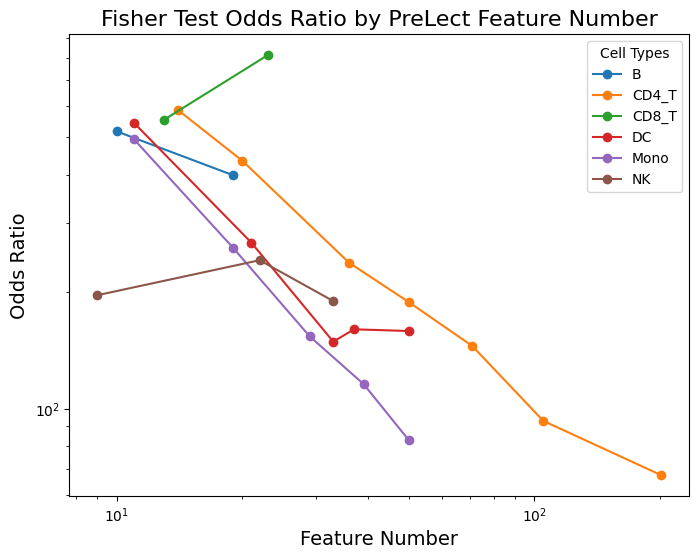

In [6]:
plt.figure(figsize=(8, 6))
for celltype in types:
    try:
        fisher_result = pd.read_csv(f'{celltype}_fisher_result.csv', index_col=0)
    except:
        print('Skipping', celltype)
        continue
    
    plt.plot(fisher_result['Feature_no'], fisher_result['Odds_ratio'], marker='o', label=celltype)

plt.xlabel('Feature Number', fontsize=14)
plt.ylabel('Odds Ratio', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.title('Fisher Test Odds Ratio by PreLect Feature Number', fontsize=16)
plt.legend(title='Cell Types')
plt.show()

Skipping other
Skipping other_T


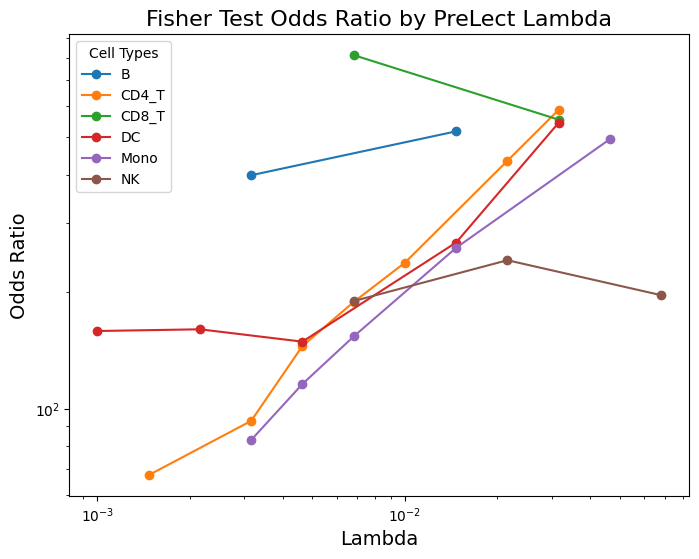

In [7]:
plt.figure(figsize=(8, 6))
for celltype in types:
    try:
        fisher_result = pd.read_csv(f'{celltype}_fisher_result.csv', index_col=0)
    except:
        print('Skipping', celltype)
        continue
    
    plt.plot(fisher_result['Lambda'], fisher_result['Odds_ratio'], marker='o', label=celltype)

plt.xlabel('Lambda', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Odds Ratio', fontsize=14)
plt.title('Fisher Test Odds Ratio by PreLect Lambda', fontsize=16)
plt.legend(title='Cell Types')
plt.show()